# 12.4f: Voronoi Population Decay Analysis

**Goal:** Test whether Qwen's black hole population distribution follows a Voronoi pattern around a primordial initialization point.

## Hypothesis

The 2,100 dead tokens were initialized near a common point **V₀** in float32 space, then quantized to bfloat16.

The 124 unique bfloat16 vectors are lattice cells, and their populations reflect how much of the float32 "cloud" around V₀ landed in each cell.

**Prediction:** Black hole population should decay with distance from V₀:
- Closest cells to V₀ → largest populations (814, 704)
- Farther cells → smaller populations (306, 228, ...)
- Farthest cells → singletons (population = 1)

## Method

1. Load the 124 unique dead token vectors and their populations
2. Find the two fattest black holes (populations 814 and 704)
3. Compute weighted centroid **V₀** = (814×BH₁ + 704×BH₂) / (814 + 704)
4. Compute L₂ and L∞ distances from each unique vector to V₀
5. Plot population vs distance

## Parameters

In [1]:
# Input paths
GAMMA_PATH = "../data/tensors/gamma_qwen3_4b_instruct_2507.safetensors"
MASK_PATH = "../data/tensors/black_hole_mask.safetensors"

# Epsilon (bfloat16 ULP at Qwen's scale)
EPSILON = 5.9604645e-05

# Figure settings
DPI = 150

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print("Loading data...\n")

# Load gamma (UNCENTERED)
gamma_data = load_file(GAMMA_PATH)
gamma = gamma_data['gamma'].to(torch.float32)
print(f"✓ Loaded γ (uncentered)")
print(f"  Shape: {gamma.shape}")

# Load black hole mask
mask_data = load_file(MASK_PATH)
mask = mask_data['mask']
print(f"\n✓ Loaded black hole mask")
print(f"  Dead tokens: {mask.sum().item():,}")

# Extract dead token embeddings
dead_tokens = gamma[mask]
print(f"\n✓ Extracted dead token embeddings")
print(f"  Shape: {dead_tokens.shape}")

Loading data...

✓ Loaded γ (uncentered)
  Shape: torch.Size([151936, 2560])

✓ Loaded black hole mask
  Dead tokens: 2,100

✓ Extracted dead token embeddings
  Shape: torch.Size([2100, 2560])


## Find Unique Vectors and Populations

In [4]:
print("\nFinding unique vectors and populations...\n")

unique_vectors, inverse_indices, counts = torch.unique(
    dead_tokens,
    dim=0,
    return_inverse=True,
    return_counts=True
)

print(f"✓ Found {len(unique_vectors)} unique vectors")
print(f"\nPopulation statistics:")
print(f"  Min: {counts.min().item()}")
print(f"  Max: {counts.max().item()}")
print(f"  Mean: {counts.float().mean().item():.1f}")
print(f"  Median: {counts.float().median().item():.0f}")

# Sort by population (descending)
sorted_counts, sorted_indices = torch.sort(counts, descending=True)

print(f"\nTop 10 populations:")
for i in range(min(10, len(sorted_counts))):
    print(f"  #{i+1}: {sorted_counts[i].item()} tokens")


Finding unique vectors and populations...

✓ Found 13 unique vectors

Population statistics:
  Min: 2
  Max: 814
  Mean: 161.5
  Median: 6

Top 10 populations:
  #1: 814 tokens
  #2: 704 tokens
  #3: 306 tokens
  #4: 228 tokens
  #5: 11 tokens
  #6: 10 tokens
  #7: 6 tokens
  #8: 5 tokens
  #9: 4 tokens
  #10: 4 tokens


## Compute V₀: Weighted Centroid of Two Fattest Black Holes

In [5]:
print("\nComputing V₀ (weighted centroid of two fattest black holes)...\n")

# Get the two fattest black holes
bh1_idx = sorted_indices[0].item()
bh2_idx = sorted_indices[1].item()

bh1_vector = unique_vectors[bh1_idx]
bh2_vector = unique_vectors[bh2_idx]

bh1_pop = sorted_counts[0].item()
bh2_pop = sorted_counts[1].item()

print(f"Black hole #1: {bh1_pop} tokens")
print(f"  Norm: {bh1_vector.norm().item():.6f}")
print(f"\nBlack hole #2: {bh2_pop} tokens")
print(f"  Norm: {bh2_vector.norm().item():.6f}")

# Weighted centroid
total_weight = bh1_pop + bh2_pop
V0 = (bh1_pop * bh1_vector + bh2_pop * bh2_vector) / total_weight

print(f"\nV₀ (weighted centroid):")
print(f"  Norm: {V0.norm().item():.6f}")
print(f"  Weight: {bh1_pop}/{total_weight} from BH1, {bh2_pop}/{total_weight} from BH2")

# Check: how far is V₀ from the two black holes?
dist_bh1_to_v0_l2 = torch.norm(bh1_vector - V0, p=2).item()
dist_bh2_to_v0_l2 = torch.norm(bh2_vector - V0, p=2).item()
dist_bh1_to_v0_linf = torch.abs(bh1_vector - V0).max().item()
dist_bh2_to_v0_linf = torch.abs(bh2_vector - V0).max().item()

print(f"\nDistances from V₀:")
print(f"  BH1 → V₀: L₂ = {dist_bh1_to_v0_l2:.6e}, L∞ = {dist_bh1_to_v0_linf:.6e} ({dist_bh1_to_v0_linf/EPSILON:.3f} ULPs)")
print(f"  BH2 → V₀: L₂ = {dist_bh2_to_v0_l2:.6e}, L∞ = {dist_bh2_to_v0_linf:.6e} ({dist_bh2_to_v0_linf/EPSILON:.3f} ULPs)")


Computing V₀ (weighted centroid of two fattest black holes)...

Black hole #1: 814 tokens
  Norm: 0.370917

Black hole #2: 704 tokens
  Norm: 0.370917

V₀ (weighted centroid):
  Norm: 0.370917
  Weight: 814/1518 from BH1, 704/1518 from BH2

Distances from V₀:
  BH1 → V₀: L₂ = 1.583178e-05, L∞ = 1.415308e-05 (0.237 ULPs)
  BH2 → V₀: L₂ = 1.830540e-05, L∞ = 1.636450e-05 (0.275 ULPs)


## Compute Distances from All Unique Vectors to V₀

In [6]:
print("\nComputing distances from all unique vectors to V₀...\n")

# L₂ distances
diffs = unique_vectors - V0.unsqueeze(0)
distances_l2 = torch.norm(diffs, p=2, dim=1)

# L∞ distances
distances_linf = torch.abs(diffs).max(dim=1)[0]

# Normalize by epsilon
distances_linf_ulps = distances_linf / EPSILON

print(f"L₂ distances to V₀:")
print(f"  Min: {distances_l2.min().item():.6e}")
print(f"  Max: {distances_l2.max().item():.6e}")
print(f"  Mean: {distances_l2.mean().item():.6e}")
print(f"  Median: {distances_l2.median().item():.6e}")

print(f"\nL∞ distances to V₀ (in ULPs):")
print(f"  Min: {distances_linf_ulps.min().item():.6f}")
print(f"  Max: {distances_linf_ulps.max().item():.6f}")
print(f"  Mean: {distances_linf_ulps.mean().item():.6f}")
print(f"  Median: {distances_linf_ulps.median().item():.6f}")


Computing distances from all unique vectors to V₀...

L₂ distances to V₀:
  Min: 1.583178e-05
  Max: 6.609265e-05
  Mean: 2.398052e-05
  Median: 1.830540e-05

L∞ distances to V₀ (in ULPs):
  Min: 0.237449
  Max: 1.024000
  Mean: 0.334769
  Median: 0.274551


## Figure 1: Population vs Distance from V₀

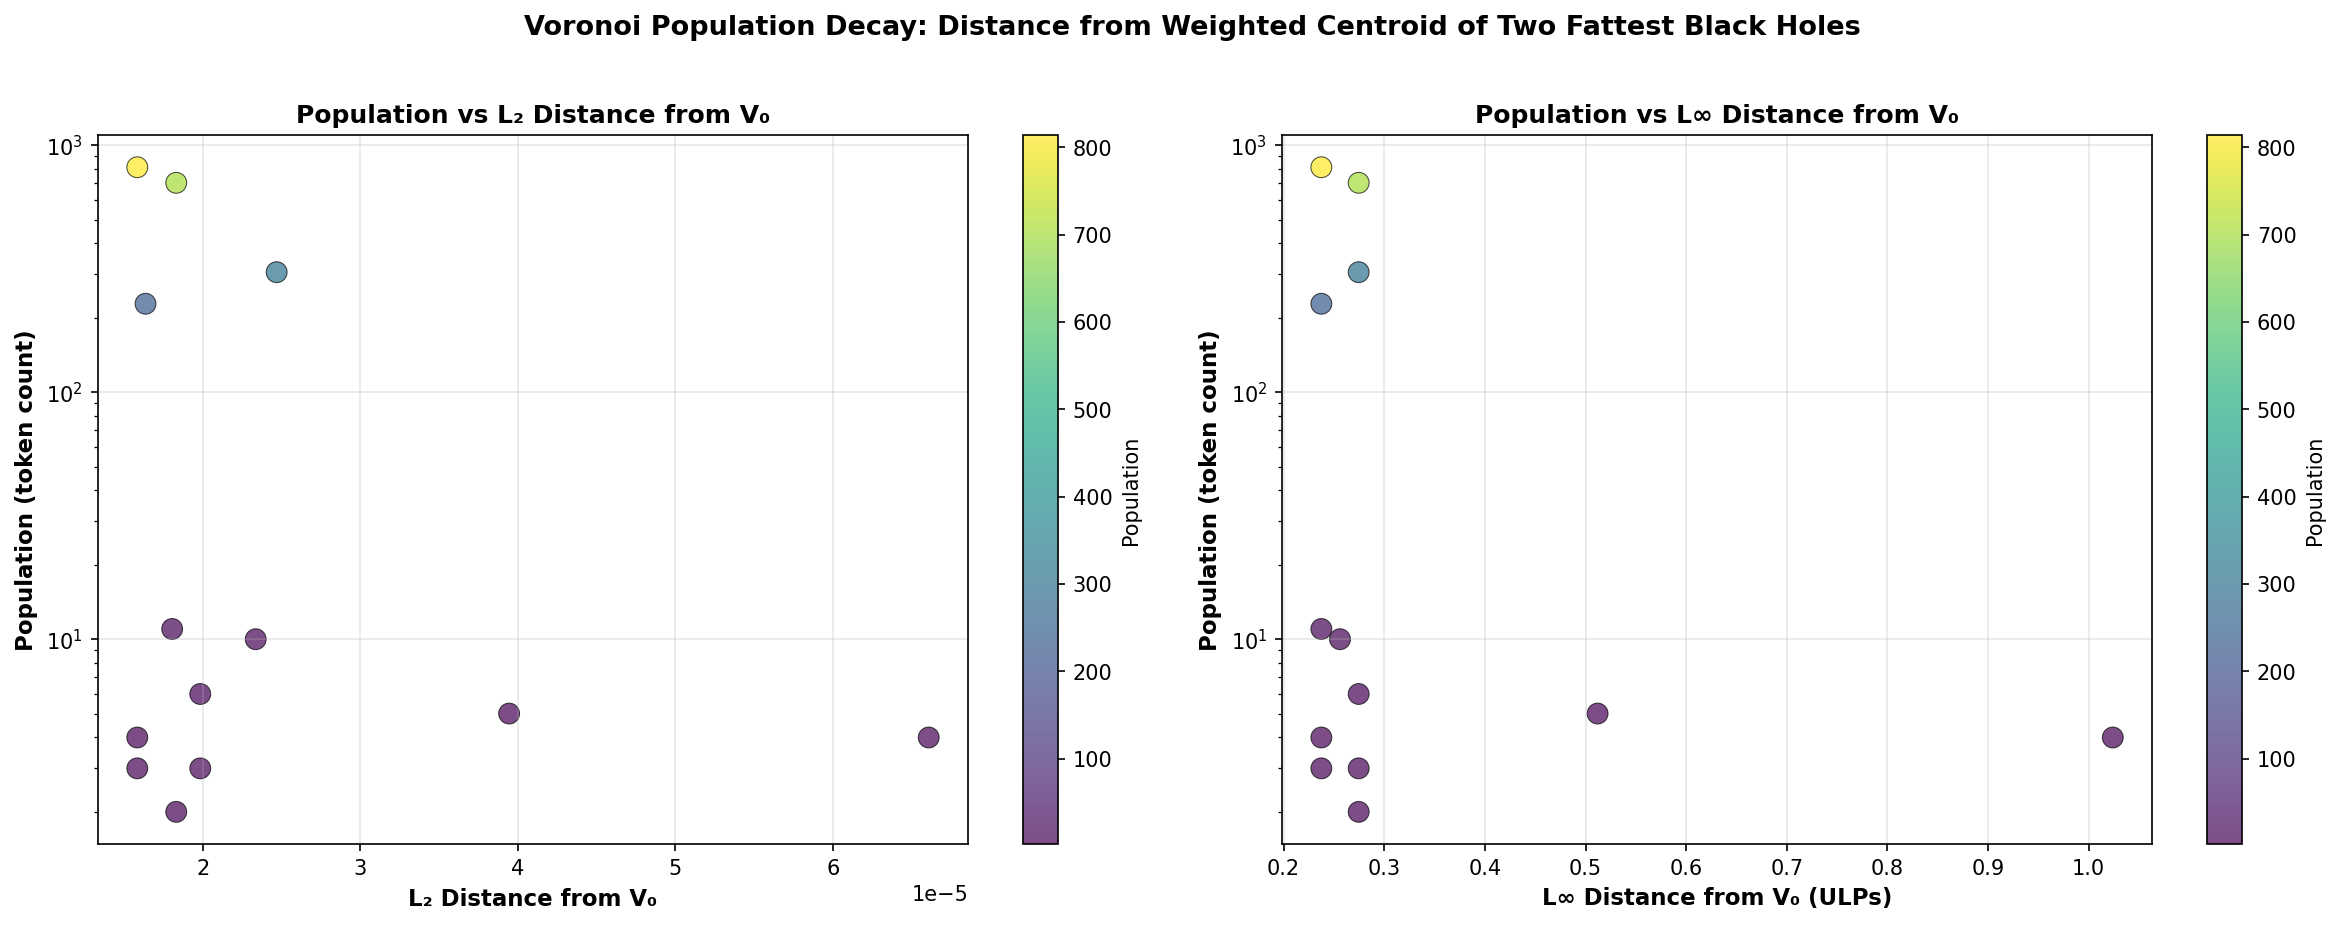

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Convert to numpy for plotting
distances_l2_np = distances_l2.cpu().numpy()
distances_linf_ulps_np = distances_linf_ulps.cpu().numpy()
counts_np = counts.cpu().numpy()

# Left panel: L₂ distance
ax = axes[0]
scatter = ax.scatter(distances_l2_np, counts_np, 
                     c=counts_np, cmap='viridis', 
                     s=100, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('L₂ Distance from V₀', fontsize=11, fontweight='bold')
ax.set_ylabel('Population (token count)', fontsize=11, fontweight='bold')
ax.set_title('Population vs L₂ Distance from V₀', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Population')

# Right panel: L∞ distance
ax = axes[1]
scatter = ax.scatter(distances_linf_ulps_np, counts_np, 
                     c=counts_np, cmap='viridis', 
                     s=100, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('L∞ Distance from V₀ (ULPs)', fontsize=11, fontweight='bold')
ax.set_ylabel('Population (token count)', fontsize=11, fontweight='bold')
ax.set_title('Population vs L∞ Distance from V₀', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Population')

plt.suptitle('Voronoi Population Decay: Distance from Weighted Centroid of Two Fattest Black Holes',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

## Figure 2: Cumulative Population vs Distance

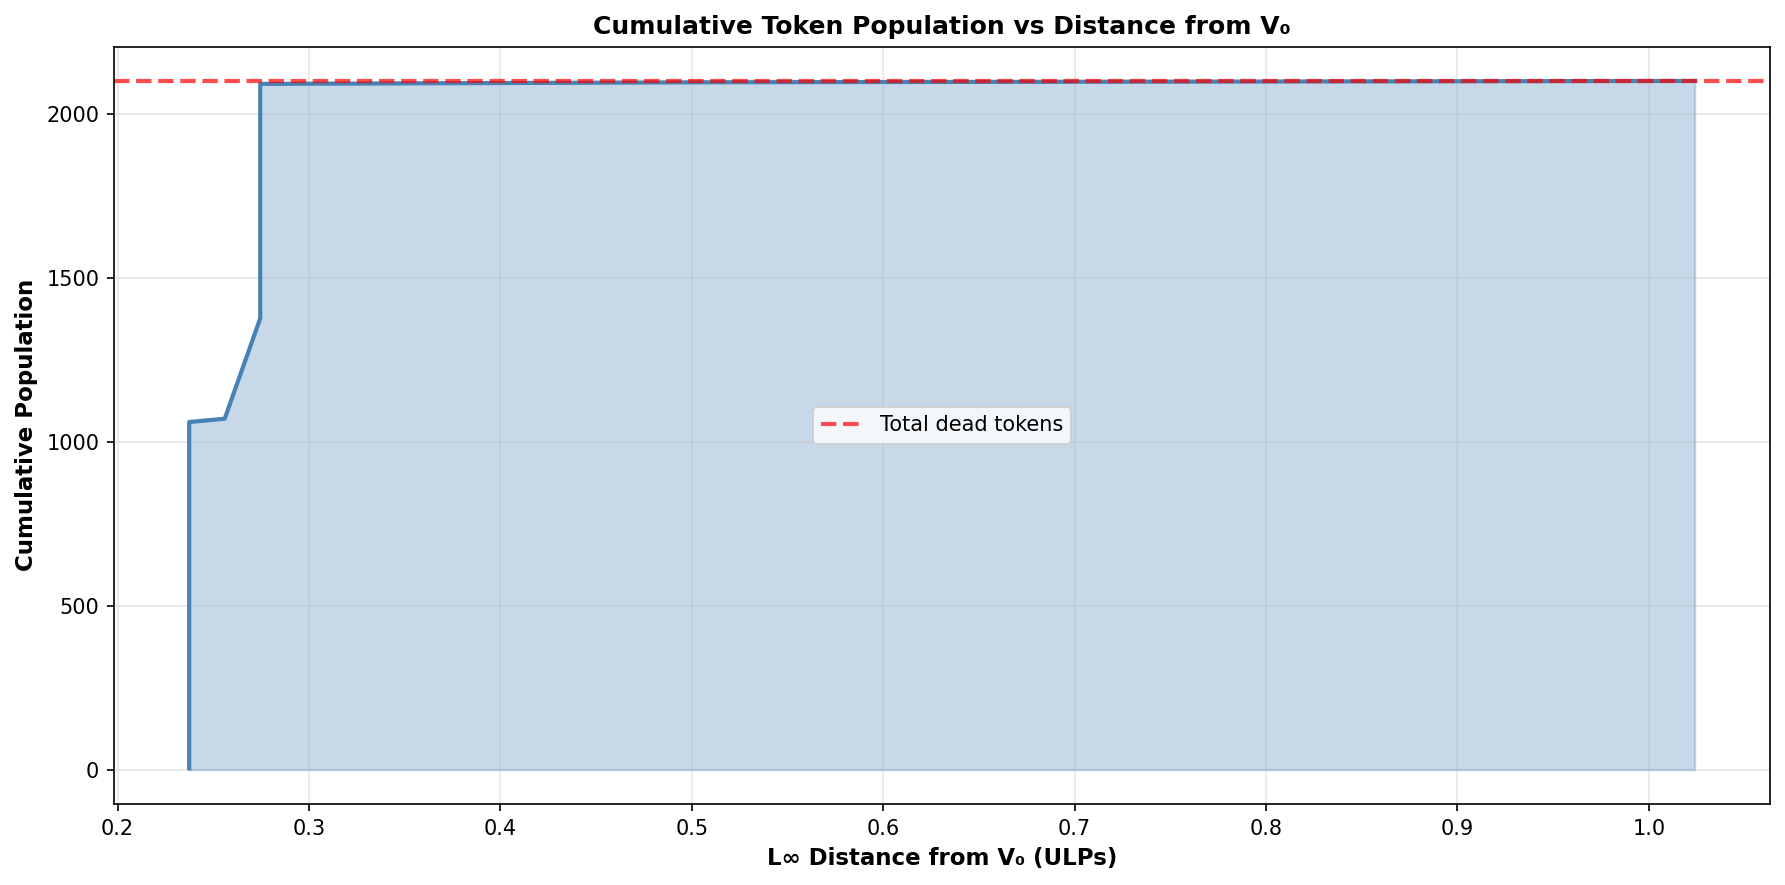


Cumulative population at distance thresholds:
  Within 0.5 ULPs: 2091 tokens (99.6%)
  Within 1.0 ULPs: 2096 tokens (99.8%)
  Within 1.5 ULPs: 2100 tokens (100.0%)
  Within 2.0 ULPs: 2100 tokens (100.0%)


In [8]:
# Sort by L∞ distance
sorted_by_dist_indices = torch.argsort(distances_linf_ulps)
sorted_distances = distances_linf_ulps[sorted_by_dist_indices].cpu().numpy()
sorted_counts = counts[sorted_by_dist_indices].cpu().numpy()

# Cumulative population
cumulative_pop = np.cumsum(sorted_counts)

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=DPI)

ax.plot(sorted_distances, cumulative_pop, linewidth=2, color='steelblue')
ax.axhline(2100, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Total dead tokens')
ax.fill_between(sorted_distances, 0, cumulative_pop, alpha=0.3, color='steelblue')

ax.set_xlabel('L∞ Distance from V₀ (ULPs)', fontsize=11, fontweight='bold')
ax.set_ylabel('Cumulative Population', fontsize=11, fontweight='bold')
ax.set_title('Cumulative Token Population vs Distance from V₀', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some quantiles
print(f"\nCumulative population at distance thresholds:")
for threshold in [0.5, 1.0, 1.5, 2.0]:
    mask = sorted_distances <= threshold
    pop_within = cumulative_pop[mask][-1] if mask.any() else 0
    pct = pop_within / 2100 * 100
    print(f"  Within {threshold:.1f} ULPs: {pop_within:.0f} tokens ({pct:.1f}%)")

## Statistical Analysis: Correlation

In [9]:
from scipy import stats as scipy_stats

# Compute correlations (use log of population to handle wide range)
log_counts = np.log10(counts_np)

# Pearson correlation
corr_l2_pearson, pval_l2_pearson = scipy_stats.pearsonr(distances_l2_np, log_counts)
corr_linf_pearson, pval_linf_pearson = scipy_stats.pearsonr(distances_linf_ulps_np, log_counts)

# Spearman correlation (rank-based, more robust)
corr_l2_spearman, pval_l2_spearman = scipy_stats.spearmanr(distances_l2_np, counts_np)
corr_linf_spearman, pval_linf_spearman = scipy_stats.spearmanr(distances_linf_ulps_np, counts_np)

print(f"\n{'='*80}")
print(f"CORRELATION ANALYSIS")
print(f"{'='*80}")
print(f"\nPearson correlation (log₁₀ population vs distance):")
print(f"  L₂ distance:  r = {corr_l2_pearson:+.4f}, p = {pval_l2_pearson:.2e}")
print(f"  L∞ distance:  r = {corr_linf_pearson:+.4f}, p = {pval_linf_pearson:.2e}")

print(f"\nSpearman correlation (rank-based, population vs distance):")
print(f"  L₂ distance:  ρ = {corr_l2_spearman:+.4f}, p = {pval_l2_spearman:.2e}")
print(f"  L∞ distance:  ρ = {corr_linf_spearman:+.4f}, p = {pval_linf_spearman:.2e}")

if corr_linf_spearman < -0.5:
    print(f"\n→ STRONG NEGATIVE CORRELATION: Population decreases with distance from V₀")
    print(f"   This supports the Voronoi hypothesis!")
elif abs(corr_linf_spearman) < 0.3:
    print(f"\n→ WEAK CORRELATION: No clear relationship between population and distance")
    print(f"   Voronoi hypothesis may not explain the distribution.")
else:
    print(f"\n→ MODERATE CORRELATION: Some relationship exists but not definitive.")

print(f"\n{'='*80}")


CORRELATION ANALYSIS

Pearson correlation (log₁₀ population vs distance):
  L₂ distance:  r = -0.2540, p = 4.02e-01
  L∞ distance:  r = -0.2600, p = 3.91e-01

Spearman correlation (rank-based, population vs distance):
  L₂ distance:  ρ = -0.1366, p = 6.56e-01
  L∞ distance:  ρ = -0.2336, p = 4.42e-01

→ WEAK CORRELATION: No clear relationship between population and distance
   Voronoi hypothesis may not explain the distribution.



## Summary

In [10]:
print(f"\n{'='*80}")
print(f"VORONOI POPULATION DECAY ANALYSIS")
print(f"{'='*80}")
print(f"\nV₀ (weighted centroid of two fattest black holes):")
print(f"  Norm: {V0.norm().item():.6f}")
print(f"  BH1 ({bh1_pop} tokens) is {dist_bh1_to_v0_linf/EPSILON:.3f} ULPs away")
print(f"  BH2 ({bh2_pop} tokens) is {dist_bh2_to_v0_linf/EPSILON:.3f} ULPs away")

print(f"\nDistance distribution (L∞ in ULPs):")
print(f"  Min: {distances_linf_ulps.min().item():.3f}")
print(f"  Max: {distances_linf_ulps.max().item():.3f}")
print(f"  Median: {distances_linf_ulps.median().item():.3f}")

print(f"\nCorrelation (population vs distance):")
print(f"  Spearman ρ = {corr_linf_spearman:+.4f} (p = {pval_linf_spearman:.2e})")

# Find singletons and their distances
singleton_mask = counts == 1
singleton_distances = distances_linf_ulps[singleton_mask]
if len(singleton_distances) > 0:
    print(f"\nSingletons (n={singleton_mask.sum().item()}):")
    print(f"  Mean distance from V₀: {singleton_distances.mean().item():.3f} ULPs")
    print(f"  Min distance: {singleton_distances.min().item():.3f} ULPs")
    print(f"  Max distance: {singleton_distances.max().item():.3f} ULPs")

print(f"\n{'='*80}")


VORONOI POPULATION DECAY ANALYSIS

V₀ (weighted centroid of two fattest black holes):
  Norm: 0.370917
  BH1 (814 tokens) is 0.237 ULPs away
  BH2 (704 tokens) is 0.275 ULPs away

Distance distribution (L∞ in ULPs):
  Min: 0.237
  Max: 1.024
  Median: 0.275

Correlation (population vs distance):
  Spearman ρ = -0.2336 (p = 4.42e-01)

